In [98]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import geodesic
from pykalman import KalmanFilter
import numpy as np
from scipy import stats

In [99]:
def charger_donnees(nomcsv, nomtel):
    """Charge les données des fichiers CSV."""
    try:
        gps_data = pd.read_csv(f'results/acquisitionsGPS/{nomcsv}.csv')
        tel_data = pd.read_csv(f'results/acquisitionsTELEPHONE/CSV/{nomtel}.csv')
        return gps_data, tel_data
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
    return None, None

In [100]:
convert_time = lambda x: datetime.strptime(x, "%Y/%m/%d - %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%SZ")

In [101]:
def fusionner_donnees(gps_data, tel_data):
    """Fusionne les données GPS et téléphone sur la colonne UTC."""
    return pd.merge_asof(
        gps_data.sort_values('UTC'),
        tel_data.sort_values('UTC'),
        on='UTC', suffixes=('_GPS', '_Tel')
    ).dropna()

In [102]:

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance haversine entre deux points GPS."""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

In [103]:
def calculer_erreurs(merged_df):
    """Ajoute une colonne de distance et affiche les statistiques d'erreur."""
    merged_df['distance'] = merged_df.apply(lambda row: haversine_distance(
        row['Latitude_GPS'], row['Longitude_GPS'], row['Latitude_Tel'], row['Longitude_Tel']), axis=1)
    print(f"Erreur moyenne : {merged_df['distance'].mean():.2f} mètres")
    print(f"Erreur max : {merged_df['distance'].max():.2f} mètres")
    print(f"Erreur min : {merged_df['distance'].min():.2f} mètres")
    return merged_df


In [104]:
def creer_dossier_sauvegarde(nomresult):
    """Crée un dossier de sauvegarde pour les résultats."""
    output_folder = f'traitements/{nomresult}'
    os.makedirs(output_folder, exist_ok=True)
    return output_folder

In [105]:
def calculer_chemin_moyen(merged_df):
    merged_df['Latitude_corrigée'] = merged_df[['Latitude_GPS', 'Latitude_Tel']].mean(axis=1)
    merged_df['Longitude_corrigée'] = merged_df[['Longitude_GPS', 'Longitude_Tel']].mean(axis=1)

In [106]:
def generer_graphiques(merged_df, output_folder):
    """Génère et sauvegarde différents graphiques de comparaison."""
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Longitude_GPS'], merged_df['Latitude_GPS'], label='GPS', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_Tel'], merged_df['Latitude_Tel'], label='Tel', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_corrigée'], merged_df['Latitude_corrigée'], label='Moyen', alpha=0.6, marker='x')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Comparaison des trajets GPS')
    plt.savefig(f'{output_folder}/comparaison_trajets.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['distance'], label='Distance GPS - Tel')
    plt.xlabel('Index')
    plt.ylabel('Distance (mètres)')
    plt.title("Évolution de l'erreur")
    plt.legend()
    plt.savefig(f'{output_folder}/erreur_evolution.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Latitude_GPS'], label='Latitude GPS')
    plt.plot(merged_df['Latitude_Tel'], label='Latitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_latitude.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Longitude_GPS'], label='Longitude GPS')
    plt.plot(merged_df['Longitude_Tel'], label='Longitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_longitude.png')
    plt.show()

In [107]:
def sauvegarder_resultats(merged_df, output_folder):
    output_file = f'{output_folder}/results.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"Résultats sauvegardés dans : {output_file}")

In [108]:
def calculer_vitesse_acceleration(df, lat_col='Latitude_GPS', lon_col='Longitude_GPS', time_col='UTC'):
    df = df.copy().sort_values(time_col)

    df['time_diff'] = df[time_col].diff().dt.total_seconds()
    df['lat_diff'] = df[lat_col].diff()
    df['lon_diff'] = df[lon_col].diff()

    df['distance_diff'] = df.apply(
        lambda row: haversine_distance(
            row[lat_col], row[lon_col],
            row[lat_col] - row['lat_diff'],
            row[lon_col] - row['lon_diff']
        ) if not np.isnan(row['lat_diff']) else np.nan,
        axis=1
    )

    df['vitesse'] = df['distance_diff'] / df['time_diff']

    df['acceleration'] = df['vitesse'].diff() / df['time_diff']

    return df

In [109]:
def generer_boxplots(df, output_folder):
    """Génère des boxplots pour la vitesse et l'accélération avec les limites des moustaches."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bp = plt.boxplot(df['vitesse'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
    plt.title('Distribution de la vitesse')
    plt.ylabel('Vitesse (m/s)')

    plt.subplot(1, 2, 2)
    bp = plt.boxplot(df['acceleration'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)

    plt.title('Distribution de l\'accélération')
    plt.ylabel('Accélération (m/s²)')
    plt.tight_layout()
    plt.savefig(f'{output_folder}/boxplots_vitesse_acceleration.png')
    plt.show()

In [110]:
def identifier_valeurs_aberrantes_boxplot(df, k=1.5):
    """
    Identifie les valeurs aberrantes en utilisant les limites des boxplots (méthode IQR).
    k: facteur pour ajuster la longueur des moustaches (typiquement 1.5)
    """
    df = df.copy()

    Q1_v = df['vitesse'].quantile(0.25)
    Q3_v = df['vitesse'].quantile(0.75)
    IQR_v = Q3_v - Q1_v
    limite_basse_v = Q1_v - k * IQR_v
    limite_haute_v = Q3_v + k * IQR_v

    Q1_a = df['acceleration'].quantile(0.25)
    Q3_a = df['acceleration'].quantile(0.75)
    IQR_a = Q3_a - Q1_a
    limite_basse_a = Q1_a - k * IQR_a
    limite_haute_a = Q3_a + k * IQR_a

    df['aberrant_vitesse'] = (df['vitesse'] < limite_basse_v) | (df['vitesse'] > limite_haute_v)
    df['aberrant_acceleration'] = (df['acceleration'] < limite_basse_a) | (df['acceleration'] > limite_haute_a)
    df['aberrant'] = df['aberrant_vitesse'] | df['aberrant_acceleration']

    df['limite_basse_vitesse'] = limite_basse_v
    df['limite_haute_vitesse'] = limite_haute_v
    df['limite_basse_acceleration'] = limite_basse_a
    df['limite_haute_acceleration'] = limite_haute_a

    return df

In [111]:
def generer_graphiques_aberrants(df, output_folder):
    """Génère des graphiques montrant les valeurs aberrantes."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(df['vitesse'], label='Vitesse normale', color='blue')
    plt.scatter(df[df['aberrant_vitesse']].index,
                df[df['aberrant_vitesse']]['vitesse'],
                color='red', label='Valeurs aberrantes')
    plt.title('Vitesse avec valeurs aberrantes')
    plt.ylabel('Vitesse (m/s)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df['acceleration'], label='Accélération normale', color='green')
    plt.scatter(df[df['aberrant_acceleration']].index,
                df[df['aberrant_acceleration']]['acceleration'],
                color='red', label='Valeurs aberrantes')
    plt.title('Accélération avec valeurs aberrantes')
    plt.ylabel('Accélération (m/s²)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{output_folder}/valeurs_aberrantes.png')
    plt.show()

In [112]:
def traitement(nomcsv, nomtel, nomresult):
    """Orchestre le traitement complet des fichiers."""
    gps_data, tel_data = charger_donnees(nomcsv, nomtel)
    if gps_data is None or tel_data is None:
        return

    gps_data['UTC'] = pd.to_datetime(gps_data['UTC'].apply(convert_time), errors='coerce')
    tel_data['UTC'] = pd.to_datetime(tel_data['UTC'], errors='coerce')

    merged_df = fusionner_donnees(gps_data, tel_data)
    merged_df = calculer_erreurs(merged_df)

    calculer_chemin_moyen(merged_df)

    merged_df = calculer_vitesse_acceleration(merged_df)

    merged_df = identifier_valeurs_aberrantes(merged_df)

    output_folder = creer_dossier_sauvegarde(nomresult)

    generer_graphiques(merged_df, output_folder)

    generer_boxplots(merged_df, output_folder)
    generer_graphiques_aberrants(merged_df, output_folder)

    sauvegarder_resultats(merged_df, output_folder)

Erreur moyenne : 19.51 mètres
Erreur max : 68.54 mètres
Erreur min : 0.43 mètres


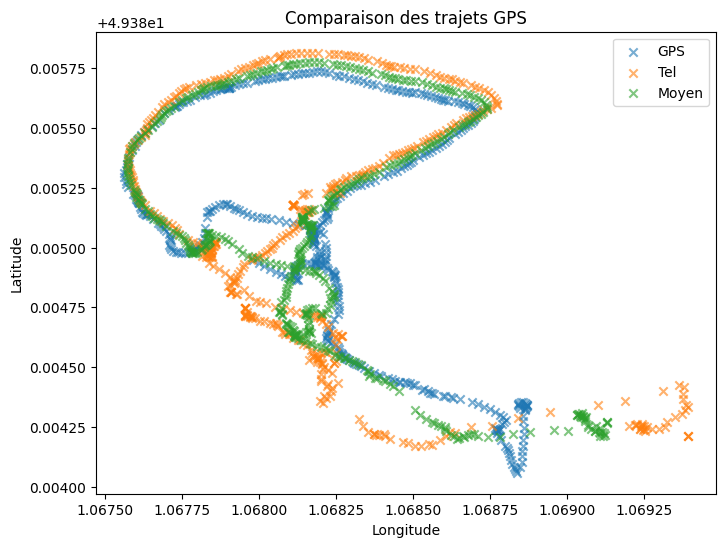

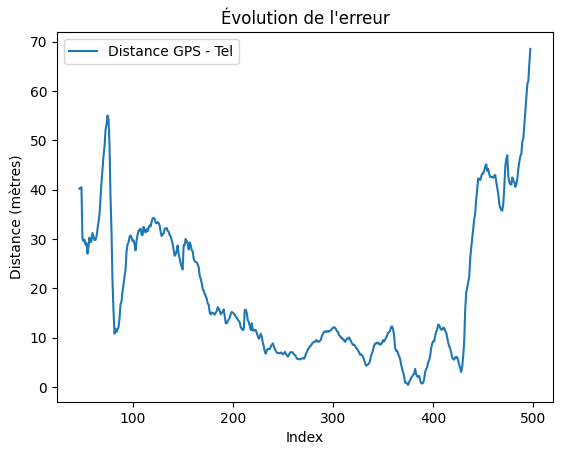

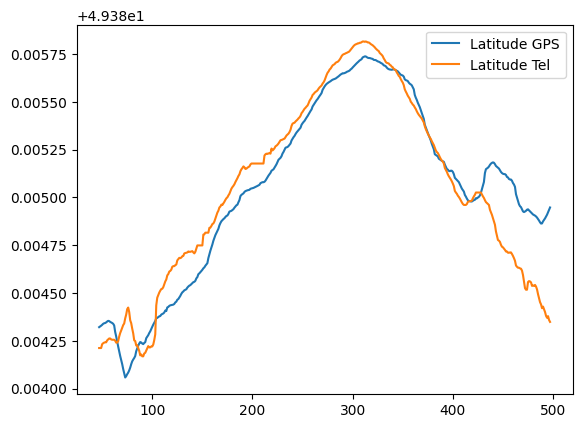

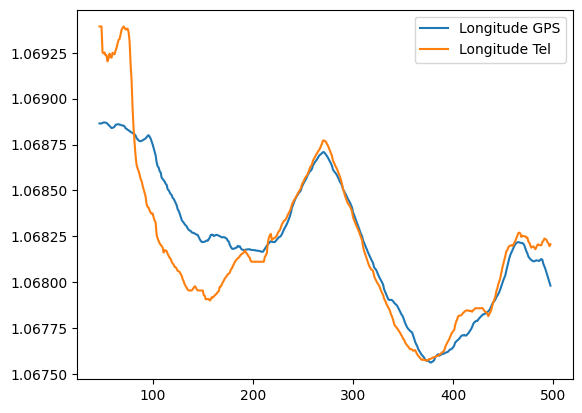

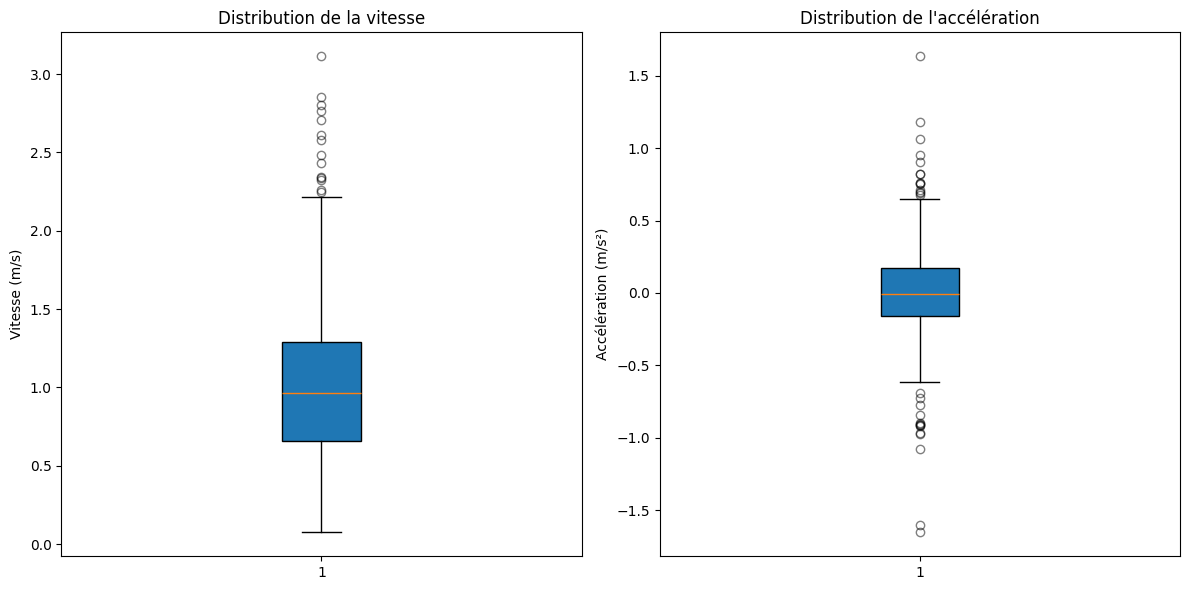

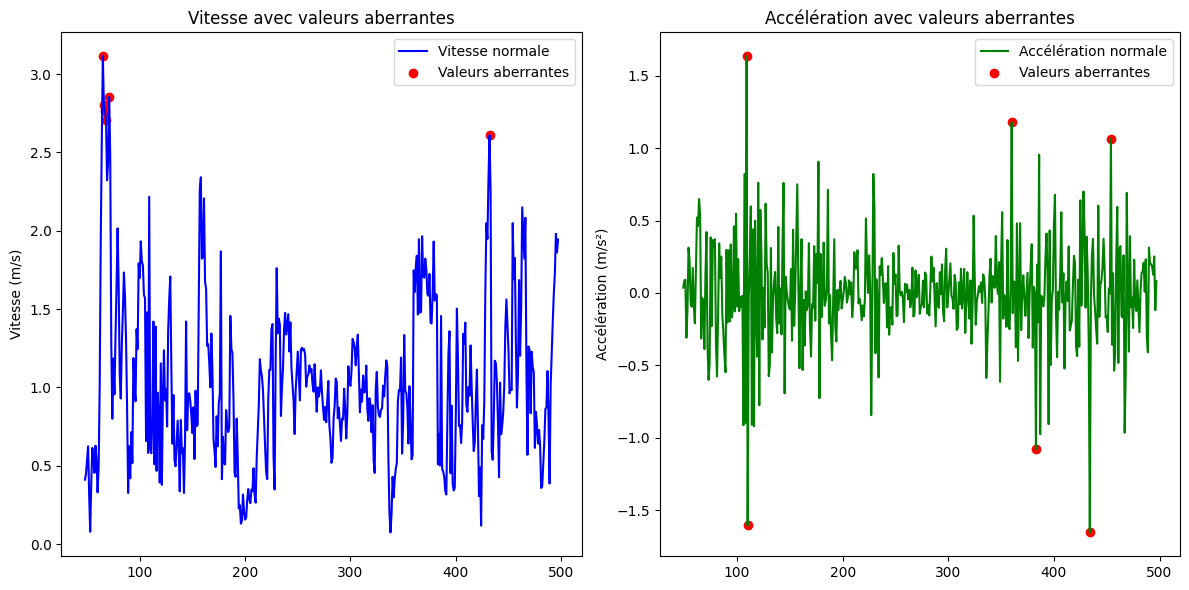

Résultats sauvegardés dans : traitements/gps1/results.csv
Erreur moyenne : 5.67 mètres
Erreur max : 5.86 mètres
Erreur min : 5.47 mètres


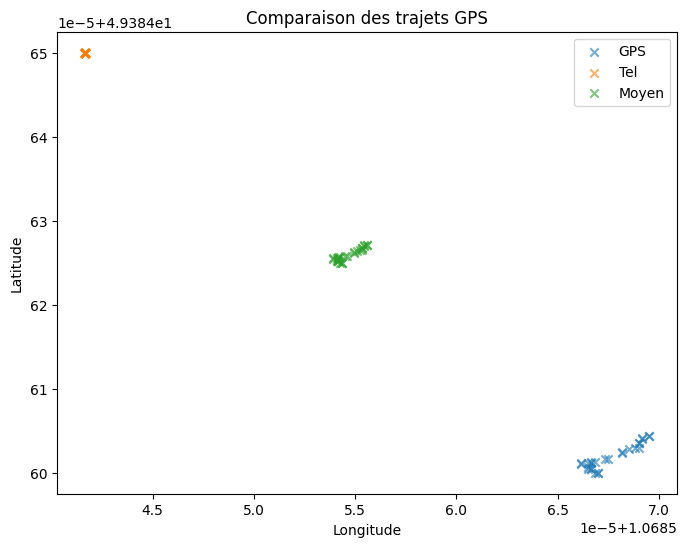

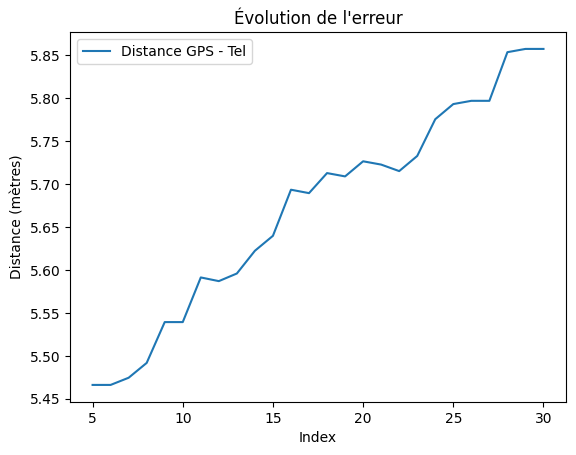

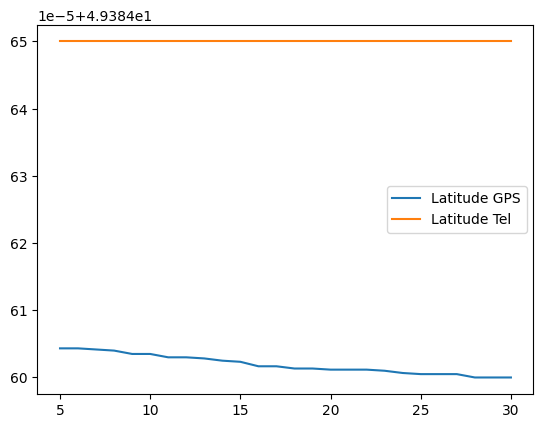

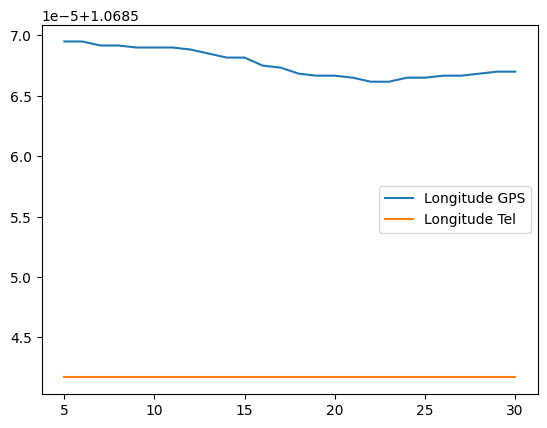

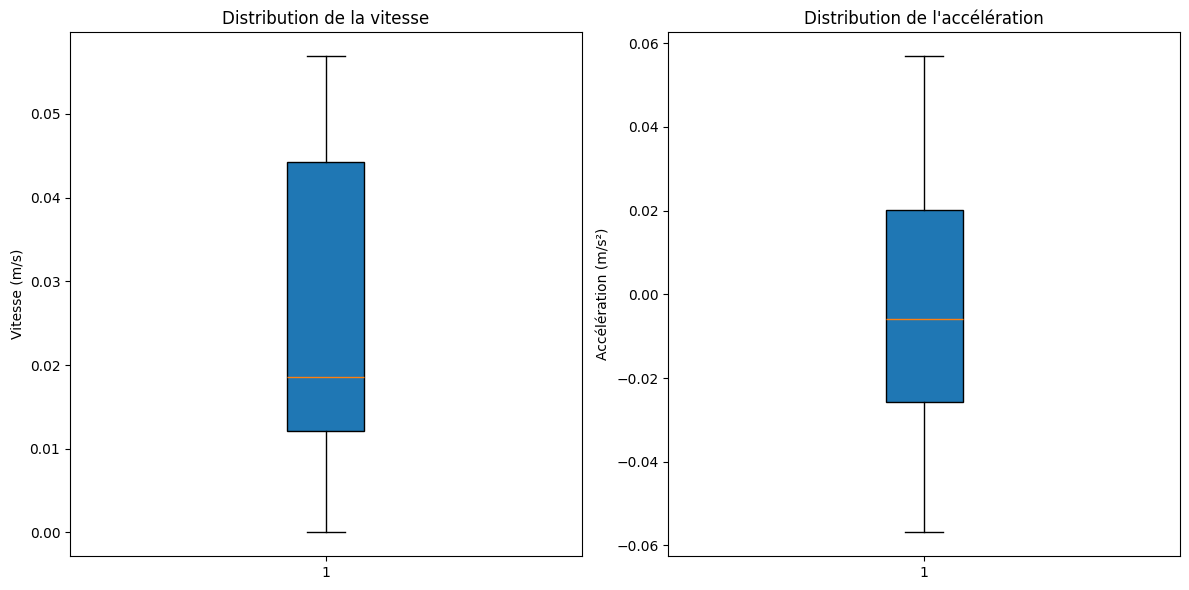

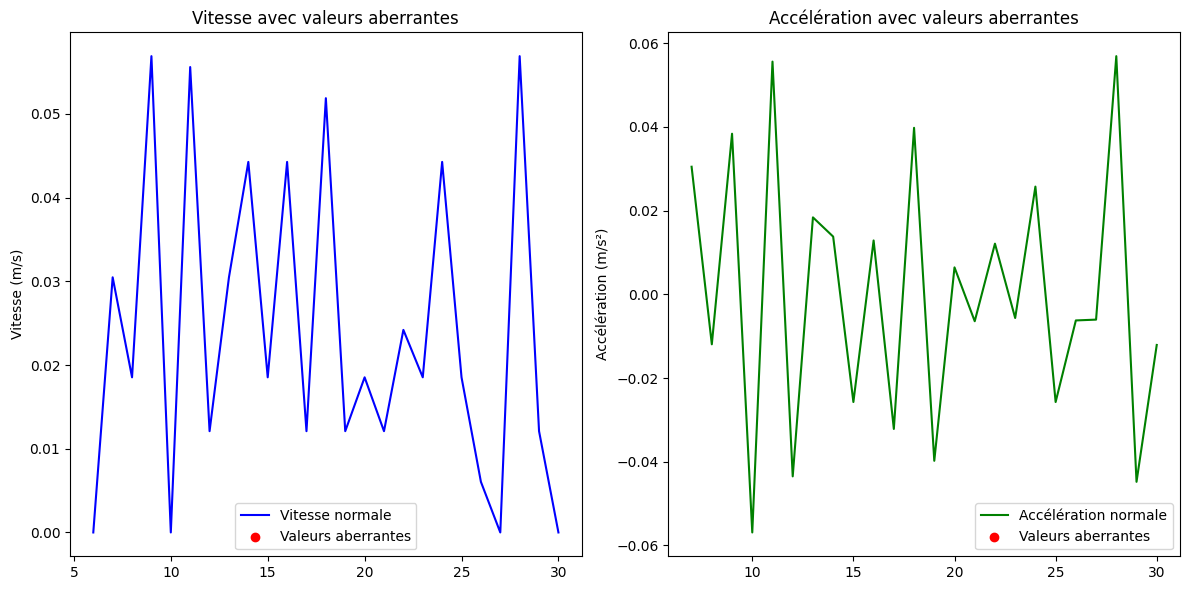

Résultats sauvegardés dans : traitements/immobile1/results.csv
Erreur moyenne : 13.27 mètres
Erreur max : 33.24 mètres
Erreur min : 1.17 mètres


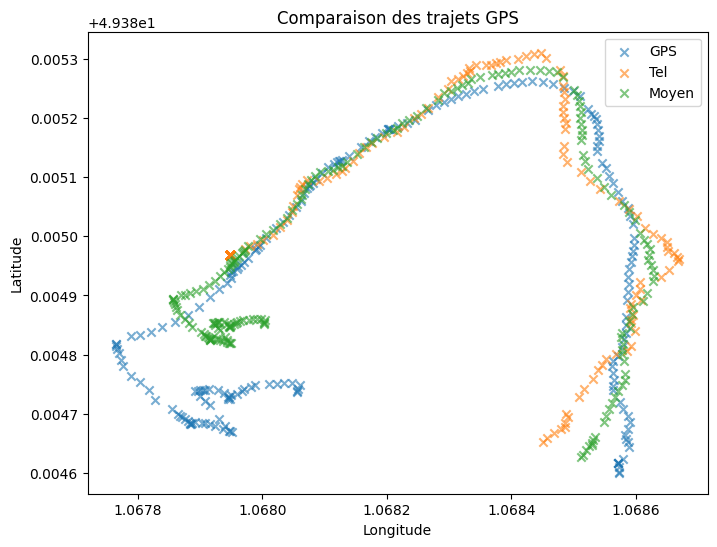

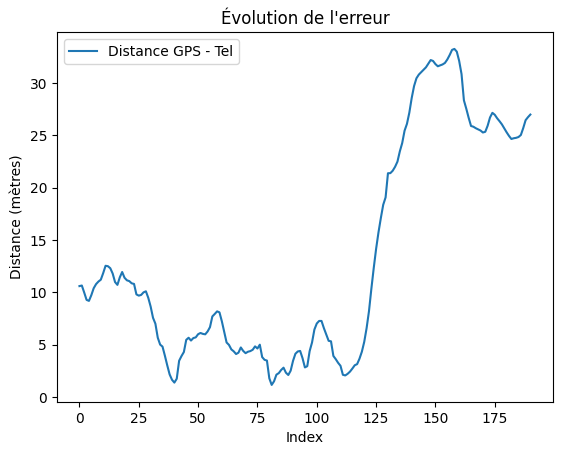

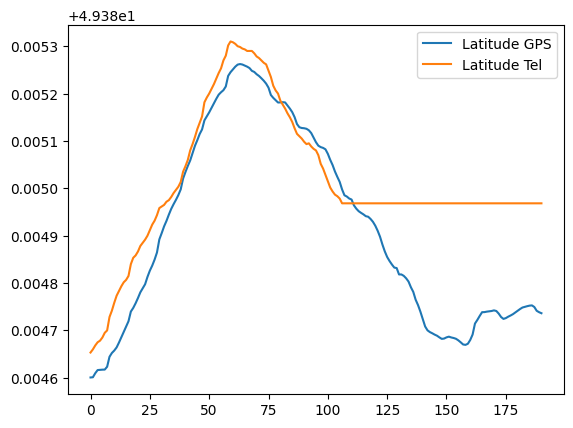

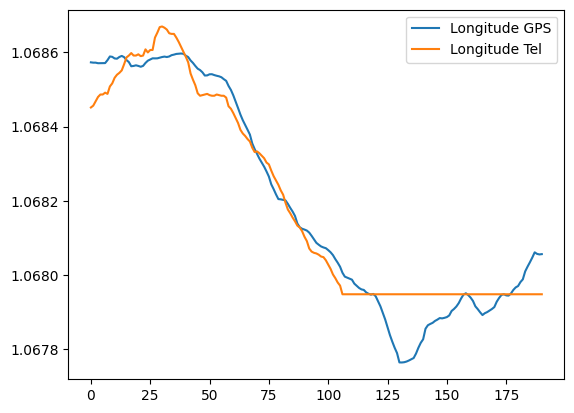

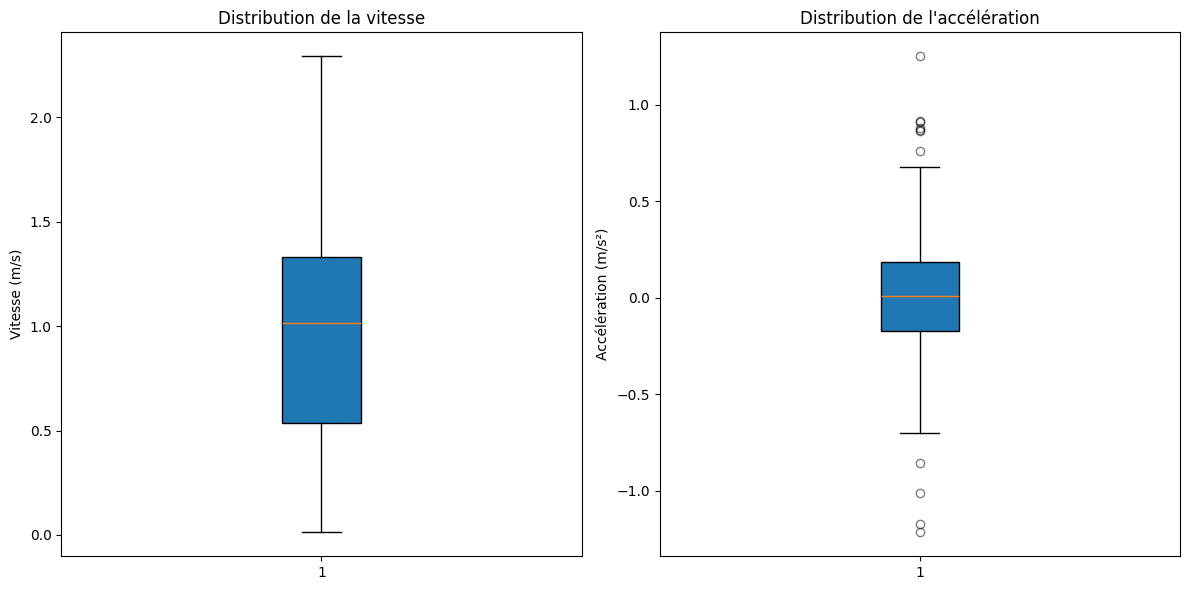

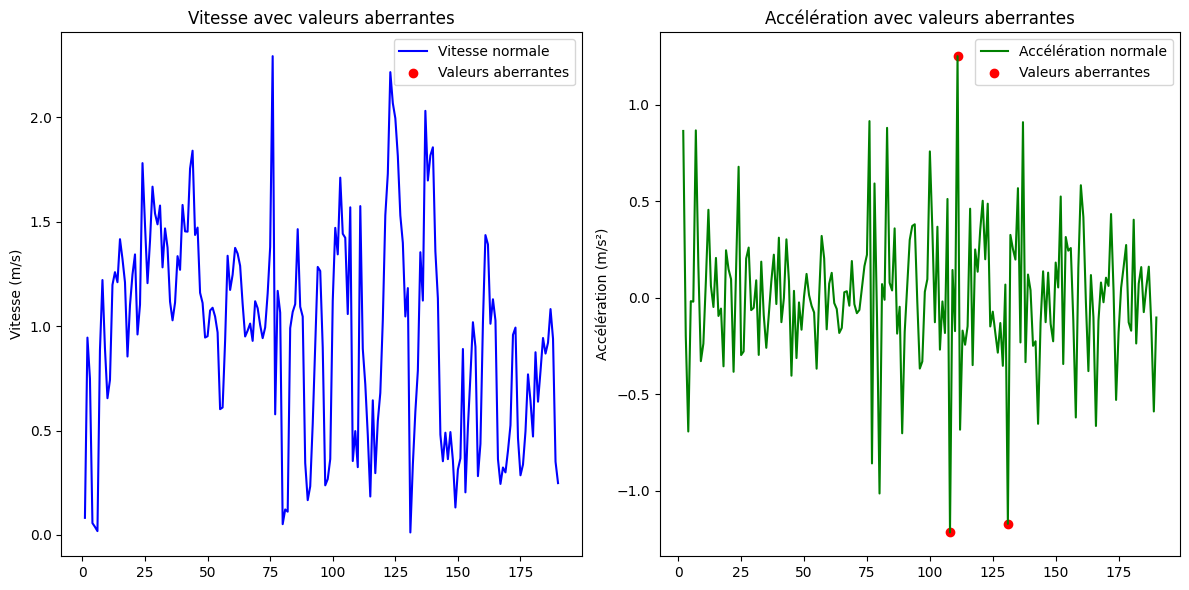

Résultats sauvegardés dans : traitements/tour_magellan1/results.csv


In [113]:
traite = {"immobile_interieur1":("immobile_interieur1","immobile_interieur1"),
          "immobile_interieur2":("immobile_interieur1","IMMOBILE_INTERIEUR1_2503"),
          "immobile_exterieur1":("immobile_exterieur1","immobile_exterieur1"),
          "immobile_exterieur2":("immobile_exterieur1","IMMOBILE_EXTERIEUR1_2503"),
          "mouvement_interieur1":("mouvement_interieur1","mouvement_interieur1"),
          "mouvement_interieur2":("mouvement_interieur1","MOUVEMENT_INTERIEUR1_2503"),
          "mouvement_exterieur1":("mouvement_exterieur1","mouvement_exterieur1"),
          "mouvement_exterieur2":("mouvement_exterieur1","MOUVEMENT_EXTERIEUR1_2503")
        }

for itineraire in traite:
    traitement(traite[itineraire][0],traite[itineraire][1],itineraire)